#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA/NSGA-II/NSGA-II/MOEA/D/IBEA/HypE/SPEA2). It is recommended to implement NSGA-II or MOEA/D. 
- Note that it has to be your implementation (using external libraries is forbidden).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, consider also the three-objective one. As for the third objective, think about some reasonable risk-measure. You can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc.

In [1]:
# TODO:
# 1. Change random initialization way ( draw n-1 numbers form 0 to 1 interval and sort them, then calculate differences between them)
# 2. Change crossover operator add to vector a drawn scalar times difference between two parents
# 3. Add mutation operator
# 4. Use third party library to calculate HV
# 5. Make plots for 3 objective case
# 6. For stocks predictions use Gaussian Mixture Model
# 20 runs
# nice 3D plot
# sensitivity analysis 4x4

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymoo.indicators.hv import HV

In [3]:
from helpers.visualizer import plot_pareto_front
from warren_buffett import WarrenBuffett

In [4]:
from moead import Instance, MOEADAlgorithm, MetricEvaluator, ScalarizingFunctionGenerator
from moead.utils import create_pareto_front

from moead.visualization.individuals import plot_igd_for_generations, get_generations_plot
from moead.visualization.pareto_front import plot_pareto_fronts

from moead.experiment import read_to_df
from moead.visualization.pareto_front import get_pareto_fronts_plot
from moead.visualization.individuals import show_all_generation_plots
from moead.visualization.igd import show_igd_heatmap

In [5]:
preds = pd.read_csv("predictions/predictions3.csv")
preds.set_index("time", inplace=True)

In [6]:
wb = WarrenBuffett(preds)
wsm_pareto_front = wb.make_me_rich()
reference_pareto = [(p, r) for (_, p, r) in wsm_pareto_front[::]]

predictions = np.array(list(wb.get_expected_returns().values()))
cov_matrix = wb.get_covariance_matrix()

instance = Instance(cov_matrix, predictions)
min_risk_solution = min(wsm_pareto_front, key=lambda x: x[1])

     pcost       dcost       gap    pres   dres
 0: -4.4257e+00 -2.7439e+00  8e+01  7e+00  6e+00
 1: -4.8412e-01 -2.6085e+00  2e+00  1e-14  1e-15
 2: -1.2234e+00 -1.7526e+00  5e-01  2e-15  6e-16
 3: -1.7294e+00 -1.7473e+00  2e-02  2e-16  7e-16
 4: -1.7438e+00 -1.7439e+00  2e-04  2e-16  6e-16
 5: -1.7439e+00 -1.7439e+00  2e-06  4e-16  7e-16
 6: -1.7439e+00 -1.7439e+00  2e-08  2e-16  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1900e-04 -1.0004e+00  1e+00  1e-16  5e+00
 1:  2.1865e-04 -1.0443e-02  1e-02  2e-16  5e-02
 2:  1.9468e-04 -4.1967e-04  6e-04  1e-16  3e-03
 3:  1.1660e-04  4.7819e-06  1e-04  5e-17  7e-19
 4:  1.0305e-04  8.2640e-05  2e-05  4e-17  4e-19
 5:  9.8710e-05  9.7158e-05  2e-06  4e-17  4e-19
 6:  9.8511e-05  9.8469e-05  4e-08  7e-17  3e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7432e-02 -1.0177e+00  1e+00  0e+00  5e+00
 1:  2.6696e-02 -2.3469e-02  5e-02  5e-17  2e-01
 2:  2.3175e-02  1.5938e

In [7]:
print(wsm_pareto_front[0])
print(max(wsm_pareto_front, key=lambda x: x[1]))

(array([1.20632825e-09, 6.85422078e-02, 4.32377532e-10, 4.32070610e-02,
       1.03510030e-02, 6.32559596e-02, 7.95977780e-03, 2.54889459e-02,
       7.10158112e-02, 9.64116755e-03, 6.48885460e-02, 8.20390181e-02,
       9.28102560e-02, 1.41632676e-02, 2.20844612e-02, 5.74553749e-02,
       7.56214709e-02, 4.22115776e-02, 1.70364776e-02, 2.32227615e-01]), 0.0677593951612833, 9.850898518082765e-05)
(array([1.75554268e-10, 4.61194887e-10, 1.26670375e-09, 9.99999942e-01,
       1.83616519e-10, 6.51951301e-10, 7.38072740e-10, 1.17198156e-09,
       9.50389882e-10, 1.37340615e-09, 6.45340949e-10, 1.38764224e-09,
       8.16215774e-10, 4.63685694e-10, 2.09840544e-09, 2.47031528e-08,
       3.89250205e-10, 7.33595976e-10, 1.91252859e-08, 4.14903860e-10]), 1.7439129898250885, 0.004557754736852854)


#### 2 objectives experiment
uncomment to run 

In [8]:
# from moead.experiment import run_experiment, read_to_df
# 
# reference_pareto = [(p, r) for (_, p, r) in wsm_pareto_front[::]]
# 
# function_numbers = [10, 30, 50, 100]
# generations = [100, 300, 500, 1_000]
# RUN_PER_CONFIG = 20
# 
# # run_experiment(instance, reference_pareto, function_numbers, generations, RUN_PER_CONFIG)

In [9]:

algorithm1 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(2, 100), population_size=100, generations=1_000, neighborhood_size=3)
metric_evaluator = MetricEvaluator(reference_pareto, generations_interval=100)
individuals_3_100_100_1000 = algorithm1.run(metric_evaluator)

igds = metric_evaluator.igd_for_generations()
metrics_2_objs_1000_gens_100_pop = metric_evaluator.get_dataframe()

pareto_front1 = create_pareto_front(individuals_3_100_100_1000, predictions, cov_matrix)

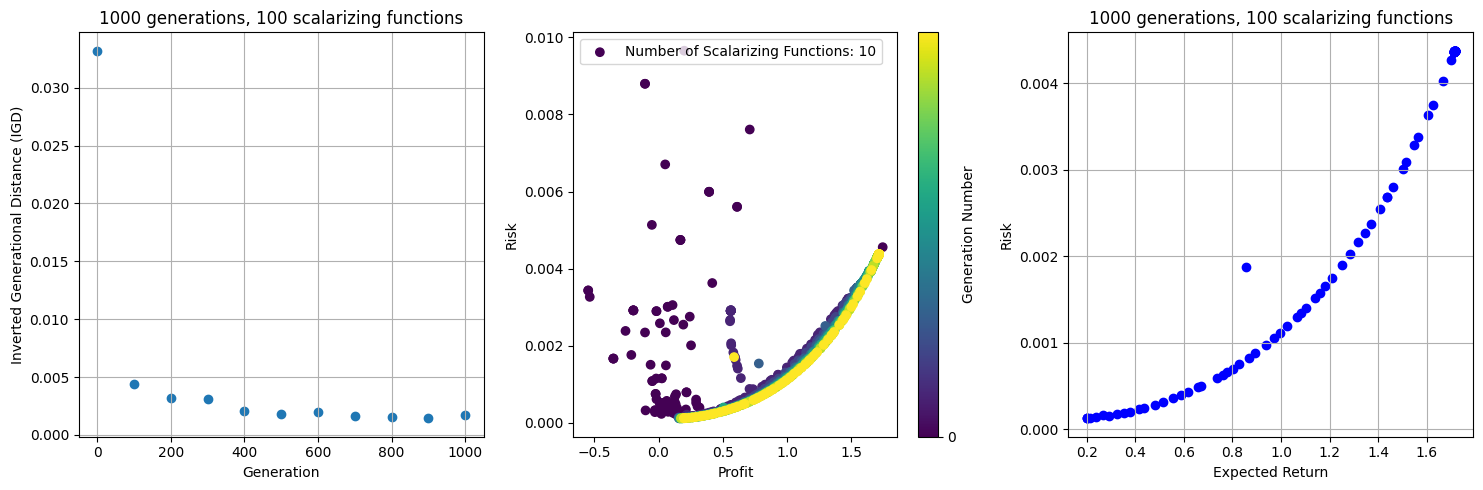

In [10]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_igd_for_generations(axs[0], igds, "1000 generations, 100 scalarizing functions")
get_generations_plot(metrics_2_objs_1000_gens_100_pop, ax=axs[1], num_scalar_funcs=10)
plot_pareto_front(axs[2], pareto_front1, title="1000 generations, 100 scalarizing functions")

plt.tight_layout()
plt.show()

In [11]:
algorithm2 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(2, 10), population_size=100, generations=10_000, neighborhood_size=3)
metric_evaluator2 = MetricEvaluator(reference_pareto, generations_interval=100)
individuals2 = algorithm2.run(metric_evaluator2)
pareto_front2 = create_pareto_front(individuals2, predictions, cov_matrix)

In [ ]:
algorithm3 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(2, 1_000), population_size=100, generations=1_000, neighborhood_size=3)
metric_evaluator3 = MetricEvaluator(reference_pareto, generations_interval=100)
individuals3 = algorithm3.run(metric_evaluator3)
pareto_front3 = create_pareto_front(individuals3, predictions, cov_matrix)

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_pareto_front(axs[0], pareto_front1, title="1000 generations, 100 scalarizing functions")
plot_pareto_front(axs[1], pareto_front2, title="10_000 generations, 10 scalarizing functions")
plot_pareto_front(axs[2], pareto_front3, title="1_000 generations, 1_000 scalarizing functions")

In [ ]:

_, ax = plt.subplots(figsize=(10, 4))
pareto_fronts = [[(p, r) for (_, p, r) in wsm_pareto_front[::]], [(p, r) for (_, p, r) in pareto_front1[::]]]
# pareto_fronts = [[(p[0], r) for (_, p, r) in wsm_pareto_front[::]], [(p, r) for (_, p, r) in pareto_front2], [(p, r) for (_, p, r) in pareto_front1[::]]]
plot_pareto_fronts(ax, pareto_fronts[::], linear_front_index=0)

In [ ]:
# def calculate_mean_igd_per_generation(all_data, reference_pareto, generations_interval=100):
#     metric_evaluator = MetricEvaluator(reference_pareto, generations_interval=generations_interval)
#     unique_run_ids = all_data['run_id'].unique()
#     combined_igds = pd.DataFrame(columns=['generation', 'igd', 'run_id'])
#     for run_id in unique_run_ids:
#         run_data = all_data[all_data['run_id'] == run_id]
#         igds = metric_evaluator.igd_for_generations_from_df(run_data)
#         igds['run_id'] = run_id
#         combined_igds = pd.concat([combined_igds, igds], ignore_index=True)
# 
#     mean_igd_per_generation = combined_igds.groupby('generation')['igd'].mean().reset_index()
#     return mean_igd_per_generation

In [ ]:

ROOT = 'experiment_results/history3'
experiment_df = read_to_df(ROOT)

In [ ]:
from moead.metrics.igd import calculate_igd_for_group

grouped = experiment_df.groupby(['Generation', 'Run_id', 'Scalar_funcs', 'TotalGenerations']).agg(list)
grouped.reset_index(inplace=True)

# Apply the calculate_igd_for_group function to each group and assign the result to a new column
grouped['IGD'] = grouped.apply(lambda x:calculate_igd_for_group(x, reference_pareto), axis=1)

In [ ]:
# Merge the grouped DataFrame back to the original DataFrame based on the grouped columns
experiment_df = pd.merge(experiment_df, grouped, on=['Generation', 'Run_id', 'Scalar_funcs', 'TotalGenerations'], how='left')
experiment_df.drop(columns=['Profit_y', 'Risk_y', 'Diversity_y'], inplace=True)
experiment_df.rename(columns={'Profit_x': 'Profit', 'Risk_x': 'Risk', 'Diversity_x': 'Diversity'}, inplace=True)
# experiment_df

In [ ]:
experiment_df['IGD'] = experiment_df['IGD'].astype(float)
experiment_df['TotalGenerations'] = experiment_df['TotalGenerations'].astype(int)
experiment_df['Scalar_funcs'] = experiment_df['Scalar_funcs'].astype(int)
experiment_df['Generation'] = experiment_df['Generation'].astype(int)
experiment_df['Run_id'] = experiment_df['Run_id'].astype(int)
experiment_df['Profit'] = experiment_df['Profit'].astype(float)
experiment_df['Risk'] = experiment_df['Risk'].astype(float)
experiment_df['Diversity'] = experiment_df['Diversity'].astype(int)

In [ ]:
mean_igd_df = experiment_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).mean().reset_index()
mean_igd_df.drop(columns=['Run_id', 'Profit', 'Risk', 'Diversity'], inplace=True)
mean_igd_df['Generation'] = mean_igd_df['Generation'].astype(int)
mean_igd_df['TotalGenerations'] = mean_igd_df['TotalGenerations'].astype(int)
mean_igd_df['Scalar_funcs'] = mean_igd_df['Scalar_funcs'].astype(int)
mean_igd_df['IGD'] = mean_igd_df['IGD'].astype(float)
# mean_igd_df

In [ ]:
_, axs = plt.subplots(mean_igd_df['TotalGenerations'].nunique(), mean_igd_df['Scalar_funcs'].nunique(), figsize=(15, 10))

min_igd = mean_igd_df['IGD'].min()
max_igd = mean_igd_df['IGD'].max()

for i, gen in enumerate(sorted(mean_igd_df['TotalGenerations'].unique())):
    for j, scalar_funcs in enumerate(sorted(mean_igd_df['Scalar_funcs'].unique())):
        data = mean_igd_df[(mean_igd_df['TotalGenerations'] == gen) & (mean_igd_df['Scalar_funcs'] == scalar_funcs)]
        ax = axs[i, j]
        ax.scatter(data['Generation'], data['IGD'])
        ax.set_ylim(min_igd, max_igd)
        if j == 0:
            ax.set_ylabel(f"Generations: {gen}", fontsize=12, fontweight='bold', rotation=90)
        if i == 0:
            ax.set_title(f"Scalarizing Functions: {scalar_funcs}", fontsize=12, fontweight='bold')
        # ax.set_title(f"Generations: {gen}, Scalarizing Functions: {scalar_funcs}")
        # ax.set_xlabel('Generation')
        # ax.set_ylabel('IGD')
        ax.grid(True)
        
plt.tight_layout()
plt.show()

#### get mean pareto across runs

In [ ]:
# Define a custom aggregation function to calculate the mean of each row across different runs
def mean_row_across_runs(values):
    # print(type(values))
    return np.mean(values.to_list(), axis=0)

# Group by the specified columns and apply the custom aggregation function
experiment_df = experiment_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations', 'Run_id']).agg({
    'Profit': list,
    'Risk': list,
    'Diversity': list
}).reset_index()

experiment_df = experiment_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).agg({
    'Profit': mean_row_across_runs,
    'Risk': mean_row_across_runs,
    'Diversity': mean_row_across_runs
}).reset_index()

experiment_df = experiment_df.explode(['Profit', 'Risk', 'Diversity'])
experiment_df.reset_index(inplace=True, drop=True)
experiment_df.Generation = experiment_df.Generation.astype(int)
# experiment_df

In [ ]:
experiment_df['Scalar_funcs'] = experiment_df['Scalar_funcs'].astype(int)
experiment_df['TotalGenerations'] = experiment_df['TotalGenerations'].astype(int)
experiment_df['Generation'] = experiment_df['Generation'].astype(int)

experiment_df = experiment_df.merge(mean_igd_df, on=['Generation', 'Scalar_funcs', 'TotalGenerations'], how='left')
# experiment_df

#### create pareto front dataframe with mean values across runs

In [ ]:
for_pareto_df = experiment_df.drop(columns = ['IGD'])
for_pareto_df = for_pareto_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).agg(list)
for_pareto_df['Pareto'] = for_pareto_df.apply(lambda x: list(zip(x['Profit'], x['Risk'])), axis=1)
for_pareto_df.drop(columns=['Profit', 'Risk', 'Diversity'], inplace=True)
for_pareto_df.reset_index(inplace=True)
# for_pareto_df

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(12, 5))

pareto_50_1000 = for_pareto_df[(for_pareto_df['Scalar_funcs'] == 50) & (for_pareto_df['TotalGenerations'] == 1000)]['Pareto'].values[-1]
pareto_100_1000 = for_pareto_df[(for_pareto_df['Scalar_funcs'] == 100) & (for_pareto_df['TotalGenerations'] == 1000)]['Pareto'].values[-1]
pareto_50_100 = for_pareto_df[(for_pareto_df['Scalar_funcs'] == 50) & (for_pareto_df['TotalGenerations'] == 100)]['Pareto'].values[-1]
pareto_100_100 = for_pareto_df[(for_pareto_df['Scalar_funcs'] == 100) & (for_pareto_df['TotalGenerations'] == 100)]['Pareto'].values[-1]

labels = ['50 funcs 1000 gens', '100 funcs 1000 gens']

# get_pareto_fronts_plot([pareto_50_1000, pareto_100_1000], ax = ax, algorithm_params={'Number of Scalarizing Functions': 50}, reference_pareto=reference_pareto, labels=labels)

get_pareto_fronts_plot([pareto_50_100], ax=axs[0, 0], algorithm_params={'Number of Scalarizing Functions': 50}, reference_pareto=reference_pareto, labels=['50 funcs 100 gens'])
get_pareto_fronts_plot([pareto_100_100], ax=axs[0, 1], algorithm_params={'Number of Scalarizing Functions': 100}, reference_pareto=reference_pareto, labels=['100 funcs 100 gens'])
get_pareto_fronts_plot([pareto_50_1000], ax=axs[1, 0], algorithm_params={'Number of Scalarizing Functions': 50}, reference_pareto=reference_pareto, labels=['50 funcs 1000 gens'])
get_pareto_fronts_plot([pareto_100_1000], ax=axs[1, 1], algorithm_params={'Number of Scalarizing Functions': 100}, reference_pareto=reference_pareto, labels=['100 funcs 1000 gens'])
axs[1,0].set_xlabel('Profit')
axs[1,1].set_xlabel('Profit')
axs[0, 1].set_ylabel('Risk')
axs[1, 1].set_ylabel('Risk')
plt.tight_layout()
plt.show()

In [ ]:

show_all_generation_plots(experiment_df)

In [ ]:

show_igd_heatmap(experiment_df)

# 3 Objectives

In [ ]:
algorithm_3_100_100_1000 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(3, 100), population_size=100, generations=1_000, neighborhood_size=3)
metric_evaluator_3_100_100_1000 = MetricEvaluator(reference_pareto, generations_interval=100)
individuals_3_100_100_1000 = algorithm_3_100_100_1000.run(metric_evaluator_3_100_100_1000)

In [ ]:
pareto_front_3_objectives = create_pareto_front(individuals_3_100_100_1000, predictions, cov_matrix, num_objectives=3)

In [ ]:

ref_point = np.array([0, 1, 0])
ind = HV(ref_point=ref_point)

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(15 ,5))
get_pareto_fronts_plot([[(p, r) for (_, p, r, _) in pareto_front_3_objectives]], ax=axs[0], algorithm_params={'Funcs': 50, 'Gen':1000}, )
get_pareto_fronts_plot([[(p, d) for (_, p, _, d) in pareto_front_3_objectives]], ax=axs[1], algorithm_params={'Funcs': 50, 'Gen':1000}, labels=['Profit', 'Diversification'])
get_pareto_fronts_plot([[(d, r) for (_, _, r, d) in pareto_front_3_objectives]], ax=axs[2], algorithm_params={'Funcs': 50, 'Gen':1000}, labels=['Diversification', 'Risk'])

for ax in axs:
    ax.set_title('Pareto Fronts')
    ax.legend(['Funcs: 50\nGen:1000'], loc='upper left')
    
axs[0].set_xlabel('Profit')
axs[0].set_ylabel('Risk')

axs[1].set_xlabel('Profit')
axs[1].set_ylabel('Diversification')

axs[2].set_xlabel('Diversification')
axs[2].set_ylabel('Risk')

plt.tight_layout()
plt.show()

print("HV", ind(np.array([np.array([-p,r,-d]) for (_, p, r, d) in pareto_front_3_objectives])))

In [ ]:
pareto_3d = np.array([np.array([p,r,d]) for (_, p, r, d) in pareto_front_3_objectives])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
n = int(np.sqrt(len(pareto_3d)))
P = pareto_3d[:-1, 0]
R = pareto_3d[:-1, 1]
D = pareto_3d[:-1, 2]
sc = ax.scatter(D, R, P, zdir='z', s=20, c=P, depthshade=True, cmap='viridis')

ax.set_xlabel('Diversification')
ax.set_ylabel('Risk')
# ax.set_zlabel('Profit')

cb = fig.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('Profit')

plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib widget 
fig = plt.figure() 
ax = plt.axes(projection= '3d')
ax.scatter3D(D, R, P, c=P, cmap='viridis')
ax.set_xlabel('Diversification')
ax.set_ylabel('Risk')

plt.show()

In [ ]:
algorithm1 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(3, 100), population_size=100, generations=5_000, neighborhood_size=3)
metric_evaluator = MetricEvaluator(reference_pareto, generations_interval=100)
individuals_100_5000 = algorithm1.run(metric_evaluator)
pareto_front_3_objectives_100_5000 = create_pareto_front(individuals_100_5000, predictions, cov_matrix, num_objectives=3)

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(15 ,5))
get_pareto_fronts_plot([[(p, r) for (_, p, r, _) in pareto_front_3_objectives_100_5000]], ax=axs[0], algorithm_params={'Funcs': 100, 'Gen':5000}, labels=['Profit', 'Risk'])
get_pareto_fronts_plot([[(p, d) for (_, p, _, d) in pareto_front_3_objectives_100_5000]], ax=axs[1], algorithm_params={'Number of Scalarizing Functions': 100}, labels=['Profit', 'Diversification'])
get_pareto_fronts_plot([[(d, r) for (_, _, r, d) in pareto_front_3_objectives_100_5000]], ax=axs[2], algorithm_params={'Number of Scalarizing Functions': 100}, labels=['Diversification', 'Risk'])
plt.tight_layout()
plt.show()

print("HV", ind(np.array([np.array([-p,r,-d]) for (_, p, r, d) in pareto_front_3_objectives_100_5000])))

In [ ]:
algorithm1 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(3, 100), population_size=100, generations=10_000, neighborhood_size=3)
metric_evaluator = MetricEvaluator(reference_pareto, generations_interval=100)
individuals_100_5000 = algorithm1.run(metric_evaluator)
pareto_front_3_objectives_100_10000 = create_pareto_front(individuals_100_5000, predictions, cov_matrix, num_objectives=3)

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(15 ,5))
get_pareto_fronts_plot([[(p, r) for (_, p, r, _) in pareto_front_3_objectives_100_10000]], ax=axs[0], algorithm_params={'Number of Scalarizing Functions': 100}, labels=['Profit', 'Risk'])
get_pareto_fronts_plot([[(p, d) for (_, p, _, d) in pareto_front_3_objectives_100_10000]], ax=axs[1], algorithm_params={'Number of Scalarizing Functions': 100}, labels=['Profit', 'Diversification'])
get_pareto_fronts_plot([[(d, r) for (_, _, r, d) in pareto_front_3_objectives_100_10000]], ax=axs[2], algorithm_params={'Number of Scalarizing Functions': 100}, labels=['Diversification', 'Risk'])
plt.tight_layout()
plt.show()

print("HV", ind(np.array([np.array([-p,r,-d]) for (_, p, r, d) in pareto_front_3_objectives_100_10000])))